## Getting Started with CUDA

In [1]:
!pip install ninja

In [2]:
import math
import os
!rm -rf /root/.cache/torch_extensions/
import torch
import torchvision

import matplotlib.pyplot as plt

from torchvision import io
from torch.utils.cpp_extension import load_inline

In [3]:
img = io.read_image("toffee.jpg")
print(img.shape)
img[:3, :3, :4]

torch.Size([3, 1440, 2560])


tensor([[[81, 82, 84, 85],
         [81, 82, 83, 85],
         [81, 82, 84, 85]],

        [[15, 16, 18, 19],
         [15, 16, 17, 19],
         [15, 16, 18, 19]],

        [[17, 18, 20, 21],
         [17, 18, 19, 21],
         [17, 18, 20, 21]]], dtype=torch.uint8)

In [4]:
def show_img(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0) # CHW -> HWC  PyTorch (CHW - Channels, Height, Width) -> matplotlib (HWC - Height, Width, Channels)
    plt.imshow(x.cpu(), **kwargs)

In [5]:
img2 = torchvision.transforms.functional.resize(img, 150, antialias=True)
ch, h, w = img2.shape
print(ch, h, w, h*w)

3 150 266 39900


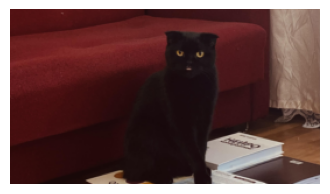

In [6]:
show_img(img2)

### RGB -> Gray

#### Basic Python

In [7]:
def rgb2grey_py(img):
    channels, height, width = img.shape
    N = height * width  # Flatten 2D matrix size
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    for i in range(N):
        res[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]
    return res.view(height, width)

In [8]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 2.37 s, sys: 8.35 ms, total: 2.37 s
Wall time: 3.65 s


In [9]:
img_g.shape

torch.Size([150, 266])

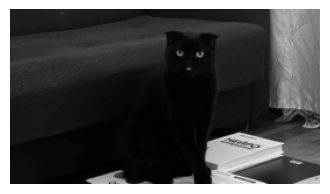

In [10]:
show_img(img_g, cmap="gray")

#### Python Kernel

In [11]:
# A kernel can not return anything. It can only change contents of things passed to it.
def run_kernel(f, times, *args):
    for i in range(times):
        f(i, *args)

In [12]:
def rgb2grey_k(i, img, out, N):
    out[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]

In [13]:
def rgb2grey_pyk(img):
    channels, height, width = img.shape
    N = height * width
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    run_kernel(rgb2grey_k, N, img, res, N)
    return res.view(height, width)

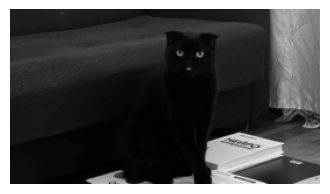

In [14]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap="gray")

#### Python Block Kernel
- **Streaming Multiprocessors (SMs):** In NVIDIA GPUs, SMs are the fundamental units of execution. Each SM can execute multiple threads concurrently.
- **Thread Blocks:** A thread block is a group of threads that can cooperate among themselves through shared memory and synchronization. All threads in a block are executed on the same SM. This means they can share resources such as shared memory and can synchronize their execution with each other.
- **Shared Memory:** Shared memory is a small memory space on the GPU that is shared among the threads in a block. It is much faster than global memory (the main GPU memory), but it is also limited in size. Threads in the same block can use shared memory to share data with each other efficiently.
- The RTX 3090, based on the Ampere architecture, has 82 SMs.
- Each SM in GA10x GPUs contain 128 CUDA Cores, four third-generation Tensor Cores, a 256 KB Register File, and 128 KB of L1/Shared Memory
- In CUDA, all threads in a block have the potential to run concurrently. However, the actual concurrency depends on the number of CUDA cores per SM and the resources required by the threads.

In [15]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads):
            f(i, j, threads, *args)

In [26]:
def rgb2gray_bk(blockIdx, threadIdx, blockDim, img, out, N):
    i = blockIdx * blockDim + threadIdx
    if i < N:
        out[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N]

In [17]:
def rgb2gray_pybk(img):
    channels, height, width = img.shape
    N = height * width
    img = img.flatten()
    res = torch.empty(N, dtype=img.dtype, device=img.device)
    threads = 256
    blocks = int(math.ceil(height * width / threads))
    blk_kernel(rgb2gray_bk, blocks, threads, img, res, N)
    return res.view(height, width)

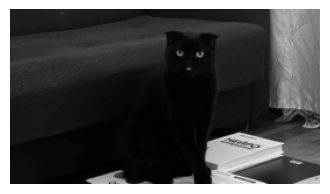

In [18]:
img_g = rgb2gray_pybk(img2)
show_img(img_g, cmap="gray")

#### CUDA

In [19]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Используем только для отладки

In [20]:
# Для захвата и отображения C-level вывода (stdout/stderr) из низкоуровневых библиотек
%load_ext wurlitzer

In [21]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(
        cuda_sources=[cuda_src],
        cpp_sources=[cpp_src],
        functions=funcs,
        extra_cuda_cflags=["-02"] if opt else [],
        verbose=verbose,
        name="inline_ext"
    )

In [22]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(img) TORCH_CHECK(img.device().is_cuda(), #img " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(img) TORCH_CHECK(img.is_contiguous(), #img "must be contiguous")
#define CHECK_INPUT(img) CHECK_CUDA(img); CHECK_CONTIGUOUS(img)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

#### CUDA Kernel

- 2^31 max blocks for dim0, 2^16 max for dim1 & dim2
- 1024 max threads per block (use a multiple of 32)
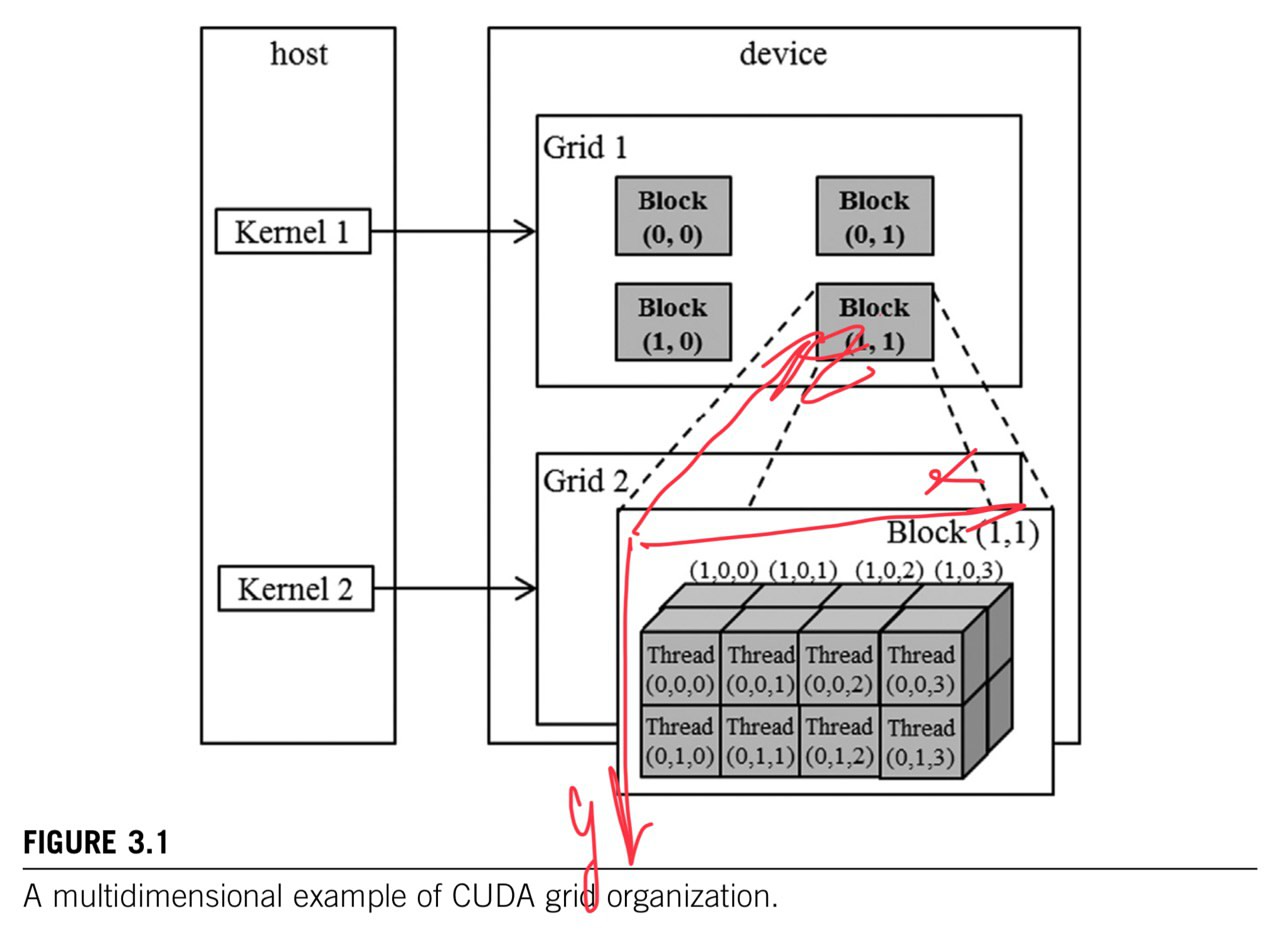

In [23]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* img, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        out[i] = 0.2989 * img[i] + 0.5870 * img[i + N] + 0.1140 * img[i + 2 * N];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
    CHECK_INPUT(input);
    int height = input.size(1);
    int width = input.size(2);
    printf("height * width: %d%d\n", height, width);
    auto output = torch::empty({height, width}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(height * width, threads)>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), height * width
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK(); /// Отлавливаем ошибки CUDA
    return output;
}
'''

In [24]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [25]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

W0903 18:41:22.302000 25946 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0903 18:41:22.302000 25946 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[1/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1018\" -isystem /usr/local/lib/python3.12/dist-packages/torch/include -isystem /usr/local/lib/python3.12/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /usr/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_75,code=compute_75 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -std=c++17 -c /root/.cache/torch_extensions/py312_cu126/inline_ext/cuda.cu -o cuda.cuda.o 
FAILED: [code=2] cuda.cuda.o 
/usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_

RuntimeError: Error building extension 'inline_ext'